## Изучение воронки продаж продуктового стартапа

В распоряжении экспериментальные данные пользователей приложения продуктового стартапа, которые были накоплены в ходе A/A/B-теста, направленного на выявление положительного/негативного влияния измененного шрифта на пользовательское поведение. 

Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

## Цель, задачи и алгоритм действий

Данное исследование направлено на выявление закономерностей пользовательского поведения при использовании мобильньного приложения магазина с разными шрифатми. В частности, планируется выявить, сколько пользователей доходит до покупки в зависимости от того, какой шрифт они видят, и какие действия они совершают в приложении прежде чем оплатить заказ. 

Посредством решения данных задач ставится цель определить, какой шрифт воспринимается пользователями лучше: старый или новый. 

Для достижения поставленной цели будут предприняты следующие шаги: 

      -открытие и изучение файла;
      -предобработка данных, включающая в себя изучение типов данных в датафрейме, его изменение в случае необходимости, 
      проверка датафрейма на наличие пропусков, дубликатов и пересечения (т.е. присутствия пользователей в нескольких 
      группах);
      -выявление количества логов, а также уникальных пользователей в датафрейме и в каждой отдельной группе; 
      -изучение периода проведения эксперимента, в частности выявление даты его начала и завершения; 
      - проверка присутствия пользователей во всех группах после корректирования исследуемого периода, а также
      выявление числа удаленных уникальных пользователей;
      -изучение воронки событий, что включает в себя выявление наиболее распространенных событий во время эксперимента,
      расчет количества уникальных пользователей, совершивших каждое событие, а также исследование последовательности
      событий и расчет доли пользователей, которая переходит на следующий шаг и доходит от первого события до оплаты заказа;
      - статистический анализ эксперимента в несколько этапов: 
          1)проверка отсутствия статистически значимых различий между контрольными группами в доле пользователей,
          ставших покупателями (A/A-эксперимент);
          2)проверка отсутствия статистически значимых различий между контрольными группами в доле пользователей,
          совершивших различные события (A/A-эксперимент);
          3)проверка отсутствия статистически значимых различий между контрольной группой №1 и экспериментальной 
          в доле пользователей, совершивших различные события (A/B-эксперимент);
          4)проверка отсутствия статистически значимых различий между контрольной группой №2 и экспериментальной
          в доле пользователей, совершивших различные события (A/B-эксперимент);
          5)проверка отсутствия статистически значимых различий суммарными показателями контрольных групп и 
          экспериментальной в доле пользователей, совершивших различные события.

In [1]:
import pandas as pd #импортируем бибилиотеку pandas для работы с датафреймом
pd.set_option('display.max_colwidth', 0)
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import matplotlib.pyplot as plt #импортируем библиотеку matpolib.byplot для того, чтобы в дальейшем присваивать осям и самим графикам названиям
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats as st #импортируем библиотеку scipy для статистического анализа
import numpy as np
import math as mth

## Изучение файла и предобработка данных

In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('logs_exp.csv', sep='\t')

**Выведем на экран первые 5 строк датафрейма для ознакомления.**

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Теперь выведем общую информацию о датафрейме, чтобы ознакомиться с типами данных и количеством пропуском в каждом столбце.**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Для удобства добавим нижние подчеркивания в названия столбцов.**

In [5]:
data = data.rename(columns = {
    'EventName':'event_name',
    'DeviceIDHash':'device_id',
    'EventTimestamp':'event_timestamp',
    'ExpId':'exp_id'})

**Пропусков в датафрейме нет. Добавим столбец даты и времени.**

In [6]:
data['event_time'] = pd.to_datetime(data['event_timestamp'],unit='s')

**Добавим столбец, в котором будет отображаться дата события.**

In [7]:
data['dt'] = data['event_time'].dt.date

**Теперь проверим, как выглядит датафрейм после изменения типа данных в столбце event_time и добавления dt.**

In [8]:
data.head()

,event_name,device_id,event_timestamp,exp_id,event_time,dt
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [9]:
print('Количество дубликатов в датафрейме:', data.duplicated().sum())

Количество дубликатов в датафрейме: 413


**Удалим дубликаты из датафрейма.**

In [10]:
data = data.drop_duplicates().reset_index()

**Изучим уникальные названия событий с целью проверки наличия среди них неявных дубликатов.**

In [11]:
data.event_name.unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

**Дубликатов нет.**

**Теперь посмотрим, есть ли в датафрейме пользователи, которые записаны сразу в несколько групп.**

In [12]:
duplicates = data.groupby('device_id').agg({'exp_id':'nunique'}).query('exp_id > 1')
print('Количество пользователей, присутствующих одновременно в нескольких группах:', len(duplicates))

Количество пользователей, присутствующих одновременно в нескольких группах: 0


## Изучение и проверка данных

### Проверка количество событий в логе

In [13]:
print('Количество событий в логе:', data.event_name.nunique())

Количество событий в логе: 5


### Проверка количества пользователей в логе

In [14]:
print('Количество пользователей в логе:', data.device_id.nunique())

Количество пользователей в логе: 7551


### Расчет среднего количества событий на пользователя

In [15]:
avg_event_count =  data.groupby('device_id').agg({'event_name':'count'}).mean()
avg_event_count

event_name    32.275593
dtype: float64

**В среднем пользователи совершили 32 события.**

**Теперь проведем подсчет медианного значения количества событий на пользователя. Этот показатель может быть более наглядным при изучении пользовательского поведения.**

In [16]:
median_event_count =  data.groupby('device_id').agg({'event_name':'count'}).median()
median_event_count

event_name    20.0
dtype: float64

**Медианное значение - 20 событий.**

### Изучение периода проведения эксперимента

**Сначала узнаем минимальную дату.**

In [17]:
data.dt.min()

datetime.date(2019, 7, 25)

**Это 25 июля 2019 г. Посмотрим на максимальную дату.**

In [18]:
data.dt.max()

datetime.date(2019, 8, 7)

**Это 7 августа 2019 г. Таким образом,  эксперимент длился 13 дней.**

**Визуалилизруем динамику эксперимента.**

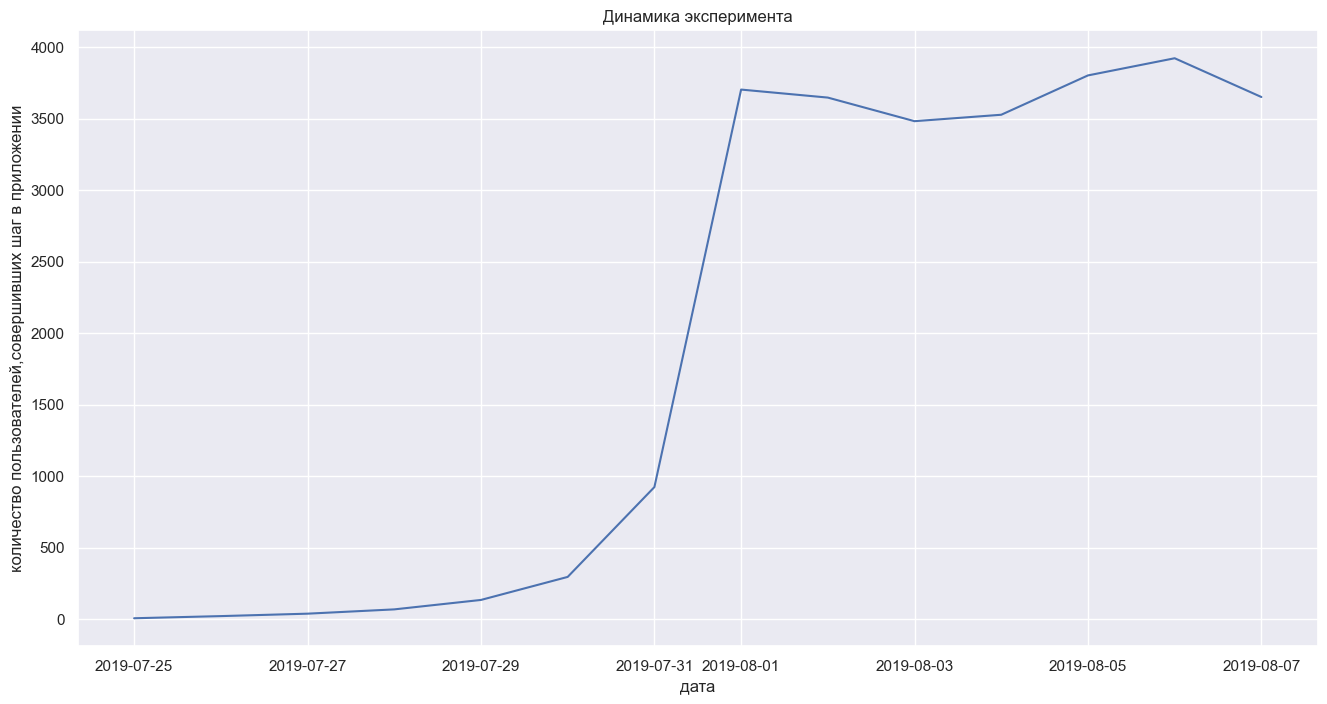

In [19]:
plt.figure(figsize=(16,8))
sns.lineplot(data=data, x='dt', y='device_id',\
             estimator='nunique', \
             ci=None, markers=True,dashes=False)
plt.title('Динамика эксперимента'),
plt.xlabel('дата'),
plt.ylabel('количество пользователей,совершивших шаг в приложении');

**На графике представлено подтвержедние того, что 25-29 июля фактически пользователи не совершали шаги в приложении, либо их количество минимально. По большому счету пользователи начали предпринимать действия в приложени лишь начиная с 31 июля.**

**Уберем 25-30 июля из анализа.Также удалим события, случившиеся до 22.00 31 июля.**

In [21]:
data_new = data.query('event_time > "2019-07-31 22:00:00"')
len(data_new)

241300

### Подсчет количества удаленных событий

In [22]:
print('Количество удаленных событий:',len(data) - len(data_new))

Количество удаленных событий: 2413


In [23]:
print('Процент удалений:', round((len(data) - len(data_new)) * 100 / len(data),2))

Процент удалений: 0.99


### Проверка присутствия пользователей в группах

In [24]:
grouped = data.groupby('exp_id').agg({'device_id':'nunique'})
grouped['device_id'] = grouped['device_id'].astype('int64')
grouped

,device_id
exp_id,
246,2489
247,2520
248,2542


**Отсутствуют значимые различия в количесте пользователей до удаления событий.**

In [25]:
grouped_new = data_new.groupby('exp_id').agg({'device_id':'nunique'})
grouped_new['device_id'] = grouped_new['device_id'].astype('int64')
grouped_new

,device_id
exp_id,
246,2484
247,2517
248,2537


**После удаления событий во всех группах есть пользователи.  Не случился перекос в количестве пользователей в пользу какой-либо группы. Это важно, поскольку в дальнейшем будет проверятся наличие стастистически значимых различий в долях пользователей.**

In [26]:
print('Количество утерянных уникальных пользователей после фильтрации данных составляет:',data.device_id.nunique() - data_new.device_id.nunique())

Количество утерянных уникальных пользователей после фильтрации данных составляет: 13


In [27]:
print('Доля утерянных уникальных пользователей составляет:',(data.device_id.nunique() - data_new.device_id.nunique()) * 100 / data.device_id.nunique())


Доля утерянных уникальных пользователей составляет: 0.17216262746656072


## Изучение воронки событий

### Изучение событий 

**Повторим код из шага 1 и выведем на экран все названия событий.**

In [28]:
data_new.event_name.unique()

array(['MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'CartScreenAppear', 'Tutorial'],
      dtype=object)

**Представлены следующие события:**

    -переход на основную страницу;
    -переход на страницу с товарами;
    -ознакомление с руководством пользователя;
    -успешное проведение оплаты;
    -переход к корзине товаров.

**Посмотрим, как часто случаются эти события.**

In [29]:
events_frequency_rating = data_new.groupby('event_name').agg({'device_id':'count'}).sort_values(by='device_id',ascending=False)
events_frequency_rating.reset_index()

,event_name,device_id
0,MainScreenAppear,117617
1,OffersScreenAppear,46420
2,CartScreenAppear,42322
3,PaymentScreenSuccessful,33935
4,Tutorial,1006


**Чаще всего происходил переход на главную страницу приложения: это событие более чем в 2 раза чаще встречается, чем остальные. Второе вместо занимает переход на страницу выбора продуктов, третье - переход на страницу с корзиной. Четвертое - оплата покупки: разница с переходом к корзине составляет окло 10 тыс. событий; значит, в ходе эксперимента значительное число пользователей отказались сталь клиентами. Возможно, у них возникли трудности с оплатой. Реже всего пользователи ознакамливались с инструкцией.** 

### Расчет количества пользователей, совершивших каждое из событий

In [31]:
#создадим сводную таблицу, содержащую количество уникальных пользователей, совершивхи каждый шаг
all_events_users = (
    data_new.pivot_table(index='event_name', values='device_id',aggfunc='nunique')
    .sort_values(by='device_id',ascending=False)
    .reset_index()
)
all_events_users.columns = [
    'event_name',
    'users_total'
]
all_events_users

,event_name,users_total
0,MainScreenAppear,7423
1,OffersScreenAppear,4595
2,CartScreenAppear,3735
3,PaymentScreenSuccessful,3539
4,Tutorial,841


In [32]:
print('Количество пользователей, совершивших каждое из событий:', all_events_users['users_total'][4])

Количество пользователей, совершивших каждое из событий: 841


**Посчитаем долю пользователей, совершивших действие в приложении.**

In [33]:
all_events_users['perc'] = round(all_events_users['users_total'] / data_new['device_id'].nunique() * 100,2)
all_events_users.sort_values(by='perc',ascending=False)

,event_name,users_total,perc
0,MainScreenAppear,7423,98.47
1,OffersScreenAppear,4595,60.96
2,CartScreenAppear,3735,49.55
3,PaymentScreenSuccessful,3539,46.95
4,Tutorial,841,11.16


**Около 1.5 % пользователей скачали приложение, но  так и не вошли в него. Также только 11% пользователей ознакомились с инструкцией, в то время как зазказ оплатили почти 47%.**

### Последовательность событий

**Продублируем сводную таблицу all_events_users, т.к. количество пользователей, совершивших действия в приложении, указывает на последовательности событий.**

In [34]:
all_events_users

,event_name,users_total,perc
0,MainScreenAppear,7423,98.47
1,OffersScreenAppear,4595,60.96
2,CartScreenAppear,3735,49.55
3,PaymentScreenSuccessful,3539,46.95
4,Tutorial,841,11.16


**События происходили в следующем порядке:**

    -переход на главную страницу приложения;
    -просмотр товаров;
    -переход в корзину;
    -оплата заказа;
    -ознакомление с руководством пользователя.

**Теперь отсортируем датафрейм data_new по пользовательски id, чтобы посмотреть на последовательность действий у отдельных пользователей.**

In [35]:
data_new.sort_values(by='device_id').head(30)

,index,event_name,device_id,event_timestamp,exp_id,event_time,dt
196914,197263,MainScreenAppear,6888746892508752,1565100394,246,2019-08-06 14:06:34,2019-08-06
208846,209210,OffersScreenAppear,6909561520679493,1565117584,247,2019-08-06 18:53:04,2019-08-06
208837,209201,MainScreenAppear,6909561520679493,1565117578,247,2019-08-06 18:52:58,2019-08-06
208836,209200,CartScreenAppear,6909561520679493,1565117578,247,2019-08-06 18:52:58,2019-08-06
208835,209199,PaymentScreenSuccessful,6909561520679493,1565117578,247,2019-08-06 18:52:58,2019-08-06
208832,209196,MainScreenAppear,6909561520679493,1565117574,247,2019-08-06 18:52:54,2019-08-06
134008,134267,MainScreenAppear,6922444491712477,1564938988,246,2019-08-04 17:16:28,2019-08-04
158365,158665,MainScreenAppear,6922444491712477,1565010769,246,2019-08-05 13:12:49,2019-08-05
158279,158579,MainScreenAppear,6922444491712477,1565010658,246,2019-08-05 13:10:58,2019-08-05
158146,158446,OffersScreenAppear,6922444491712477,1565010517,246,2019-08-05 13:08:37,2019-08-05


**На примере 3 пользователей видно, что нет четкой последовательности, по которой пользователи совершали действия в приложения.**

In [36]:
print('Доля покупателей, которая ознакомилась с инструкцией:', round(all_events_users['users_total'][4] / all_events_users['users_total'][3] * 100, 2))

Доля покупателей, которая ознакомилась с инструкцией: 23.76


**Удалим ознакомление с руководством пользователя из числа событий. Лишь 23% покупателей ознакомились с ним.**

In [37]:
data_new = data_new.query('event_name != "Tutorial"')

### Расчет доли пользователей, которая проходит на следующий шаг воронки событий

In [38]:
all_events_users = all_events_users.query('event_name !="Tutorial"')
all_events_users['stage_loss'] = 100 - all_events_users['perc']

In [39]:
all_events_users.sort_values(by='perc',ascending=False)

,event_name,users_total,perc,stage_loss
0,MainScreenAppear,7423,98.47,1.53
1,OffersScreenAppear,4595,60.96,39.04
2,CartScreenAppear,3735,49.55,50.45
3,PaymentScreenSuccessful,3539,46.95,53.05


In [41]:
events_and_groups = (
    data_new.pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique')
    .sort_values(by=246,ascending=False)
    .reset_index()
)
events_and_groups[249] = events_and_groups[246] + events_and_groups[247]
events_and_groups

exp_id,event_name,246,247,248,249
0,MainScreenAppear,2450,2479,2494,4929
1,OffersScreenAppear,1542,1522,1531,3064
2,CartScreenAppear,1266,1239,1230,2505
3,PaymentScreenSuccessful,1200,1158,1181,2358


**Рассчитаем  для каждой группы доли пользователей, переходящих на следующий шаг воронки.**

In [42]:
#получим доли в первой контрольной группе
info_246 = events_and_groups[['event_name', 246]]
info_246['stage_loss'] = round((info_246[246]/info_246[246].shift())*100, 2)
info_246

exp_id,event_name,246,stage_loss
0,MainScreenAppear,2450,NaN
1,OffersScreenAppear,1542,62.94
2,CartScreenAppear,1266,82.10
3,PaymentScreenSuccessful,1200,94.79


In [43]:
#получим доли во второй контрольной группе
info_247 = events_and_groups[['event_name', 247]]
info_247['stage_loss'] = round((info_247[247]/info_247[247].shift())*100, 2)
info_247

exp_id,event_name,247,stage_loss
0,MainScreenAppear,2479,NaN
1,OffersScreenAppear,1522,61.40
2,CartScreenAppear,1239,81.41
3,PaymentScreenSuccessful,1158,93.46


In [44]:
#получим доли в экспериментальной группе
info_248 = events_and_groups[['event_name', 248]]
info_248['stage_loss'] = round((info_248[248]/info_248[248].shift())*100, 2)
info_248

exp_id,event_name,248,stage_loss
0,MainScreenAppear,2494,NaN
1,OffersScreenAppear,1531,61.39
2,CartScreenAppear,1230,80.34
3,PaymentScreenSuccessful,1181,96.02


In [45]:
#получим доли в экспериментальной группе
info_249 = events_and_groups[['event_name', 249]]
info_249['stage_loss'] = round((info_249[249]/info_249[249].shift())*100, 2)
info_249

exp_id,event_name,249,stage_loss
0,MainScreenAppear,4929,NaN
1,OffersScreenAppear,3064,62.16
2,CartScreenAppear,2505,81.76
3,PaymentScreenSuccessful,2358,94.13


**Серьезных различий между группами, как видно, нет. Доли пользователей, переходящих на следующий шаг воронки, в экспериментальной группах даже меньше, чем в контрольных.**

### Расчет доли пользователей, совершившвшей все шаги 

**Чтобы расчитать долю пользователей, разделим количество пользователей, совершивших финальный шаг (оплату заказа)  и тех, кто зашел на главную страницу приложения.** 

In [47]:
all_events_perc = round(all_events_users['users_total'][3] / all_events_users['users_total'][0] * 100 , 2)
print('Доля пользователей, совершившая все шаги:', all_events_perc)


Доля пользователей, совершившая все шаги: 47.68


## Изучение результатов эксперимента

### Выявление количества пользователей в экспериментальных группах

In [48]:
funnel_data_by_group = data_new.pivot_table(index='exp_id', values='device_id', aggfunc='nunique').reset_index()


**В контрольных группах 2483 и 2516 пользователей соответственно. В экспериментальной - 2535.**

### Изучение статистической разницы между выборками 246 и 247

**Проверим, есть ли статистически значимые различия между контрольными группами в доле пользователей, ставших покупателями.**

In [49]:
#получим количество пользователей, оплативших заказ в тестовых и экспериментальной группах 
payment_success_user_count = (
    data_new.loc[data_new['event_name'] == 'PaymentScreenSuccessful']
    .pivot_table(index='exp_id', values='device_id', aggfunc='nunique')
    .reset_index()
    )

payment_success_user_count

,exp_id,device_id
0,246,1200
1,247,1158
2,248,1181


**Сформулируем нулевую гипотезу следующим образом: "Отствует статистически значимые различия  между выборками 246 и 247 в доле пользователей,ставших покупателями". Альтернативная гипотезу:"Cуществуют статистически значимые различия  между выборками 246 и 247 в доле пользователей, ставших покупателями".** 

In [50]:
alpha = .01 # критический уровень статистической значимости

users = np.array([funnel_data_by_group['device_id'][0], funnel_data_by_group['device_id'][1]])
buyers = np.array([payment_success_user_count['device_id'][0], payment_success_user_count['device_id'][1]])

# пропорция успехов в первой группе:
p1 = buyers[0]/users[0]

# пропорция успехов во второй группе:
p2 = buyers[1]/users[1]

# пропорция успехов в комбинированном датасете:
p_combined = (buyers[0] + buyers[1]) / (users[0] + users[1])

# разница пропорций в датасетах
difference = p1 - p2


# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

In [51]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.10288527362638322
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**P-значение, т.е. вероятность получить в реальном наблюдении значение, далекое от предполагаемого в нулевой гиоптезе, больше установленного уровня статистической значимости (1%). Значит придерживаемся гипотезы об отсутствии статистически значимых отличий в долях покупатеелй между контрольными группами. Отсутствие значимых различий между контрольными группами важно для качественного проведения A/A-эксперимента.**

### Изучение статистической разницы между выборками 246 и 247 в доле пользователей, совершивших наиболее популярное событие

**Построим график динамики эксперимента с учетом типа событий. Также визуализируем количество уникальных пользователей, совершивших тот или иной шаг из эксперимента.**

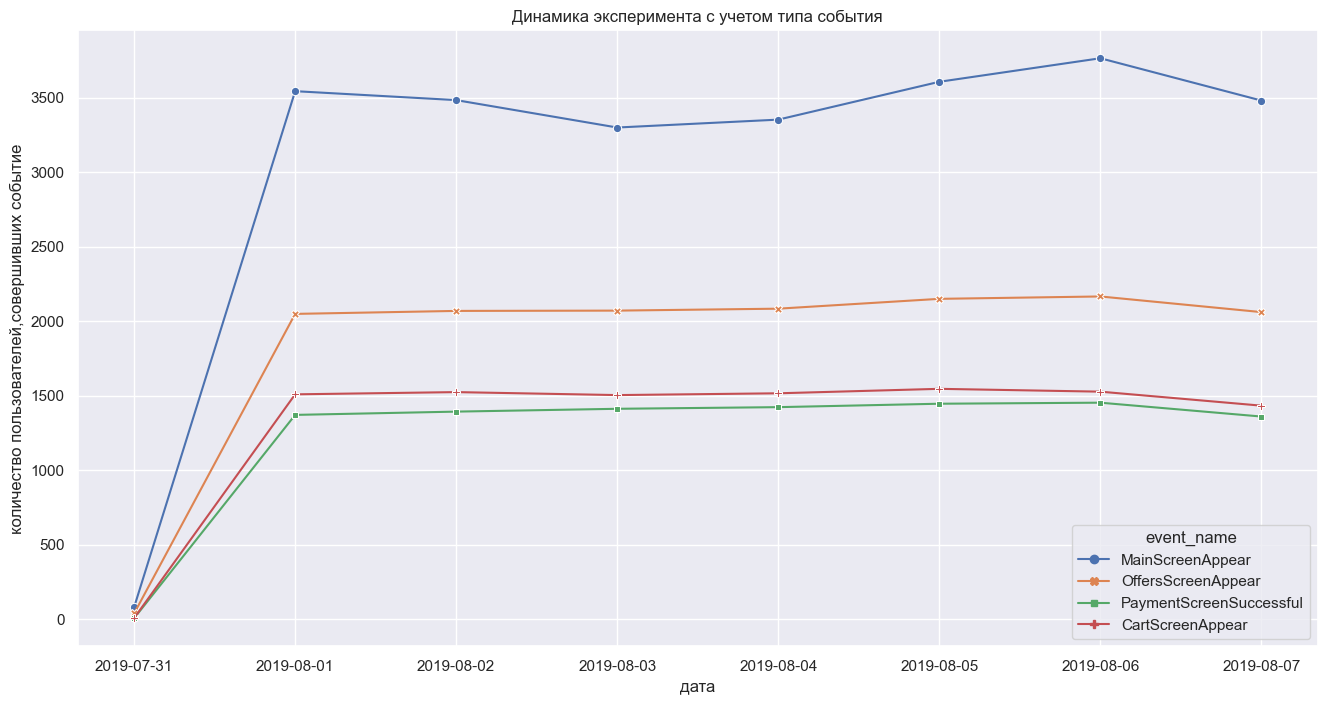

In [52]:
plt.figure(figsize=(16,8))
sns.lineplot(data=data_new, x='dt', y='device_id',\
             hue='event_name', estimator='nunique', style='event_name', \
             ci=None, markers=True,dashes=False)
plt.title('Динамика эксперимента с учетом типа события'),
plt.xlabel('дата'),
plt.ylabel('количество пользователей,совершивших событие');

**Как видно на графике, на протяжении всего эксперимента самым популярным событием было посещение главной страницы мобильного приложения. Отрыв от остальных событий довольно большой: в то время как 3400-3700 пользователей зашли на главную страницы, лишь 2100 перешли на страницу выбора товаров.**

**При помощи создания сводной таблицы удалось узнать, что переход на главную страницу мобильного приложения является  самым популярным шагом. Виден очень сильный отрыв по количеству пользователей от остальных событий. Существует вероятность того, что некоторые пользователи не находят интерфейс удобным. В случае с большим оттоком пользователей после просмотра главной страницы нельзя говорить о наличии технической ошибки. Скорее всего, надо улучшать UX.** 

In [53]:
event_info = (
    data_new.pivot_table(index='event_name', columns='exp_id',values='device_id', aggfunc='nunique')
    .sort_values(by=246,ascending=False)
)
#добавим  суммарные значения обеих контрольных групп
event_info['249'] = event_info[246] + event_info[247]
event_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, MainScreenAppear to PaymentScreenSuccessful
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   246     4 non-null      int64
 1   247     4 non-null      int64
 2   248     4 non-null      int64
 3   249     4 non-null      int64
dtypes: int64(4)
memory usage: 160.0+ bytes


**Посчитаем долю пользователей,совершивших переход на главную страницу.**

In [54]:
main_screen_appear_user_count = (
     data_new.loc[data_new['event_name'] == 'MainScreenAppear']
    .pivot_table(index='exp_id', values='device_id', aggfunc='nunique')
    .reset_index()
    )
main_screen_appear_user_count['perc'] = round(main_screen_appear_user_count['device_id'] / funnel_data_by_group['device_id'] * 100, 2)
main_screen_appear_user_count

,exp_id,device_id,perc
0,246,2450,98.67
1,247,2479,98.53
2,248,2494,98.38


**Как видно ниже, менее 2% привлеченных пользователей никак не ознакомились с приложением.В целом, показатель хороший.**

**Узнаем показатель доли пользователей с учетом суммарного количества пользователей из контрольных групп.**

In [55]:
main_screen_appear_user_count.loc[len(main_screen_appear_user_count.index)] = ['249', '4929', '98.6']
main_screen_appear_user_count

,exp_id,device_id,perc
0,246,2450,98.67
1,247,2479,98.53
2,248,2494,98.38
3,249,4929,98.6


In [56]:
#повторно сгруппируем пользователям по выборкам
users_per_group = data_new.groupby('exp_id').agg({'device_id':'nunique'})
users_per_group

,device_id
exp_id,
246,2483
247,2516
248,2535


In [57]:
#добавим столбец с суммарным количеством пользователей из контрольных выборок
total_246_and_247 = users_per_group.iloc[0] + users_per_group.iloc[1]
total_246_and_247.name = '249'
users_per_group_merge = users_per_group.append([total_246_and_247])
users_per_group_merge

,device_id
exp_id,
246,2483
247,2516
248,2535
249,4999


**Проведем тест для остальных шагов. Оптимизации процесса тестирования долей пользователей на отсутствие статистически значимых различий будет осуществлена при помощи функции.** 

**Проведем 4  проверки долей пользователей из выборок 246 и 247, совершивших оставшиеся действия в приложении:**
   
    - Нулевая гипотеза - "доли уникальные пользователей, побывавших на этапе воронки,у контрольных групп одинаковы".
    - Альтернативная гипотеза - "между долями уникальных посетителей контрольных групп, побывавших на этапе воронки, есть значимая разница".;

**Поскольку сравниваются две контрольные выборки, уровнем статистической значимости будет 1%.**

In [58]:
def hypothesis_test(group1, group2, alpha): 
    
    events_one = event_info.loc[event, group1]
    events_two = event_info.loc[event, group2] 
    users_one = users_per_group_merge.loc[group1, 'device_id'] 
    users_two = users_per_group_merge.loc[group2,'device_id'] 
    
    # пропорция успехов в первой группе:
    p1 = events_one / users_one 
    # пропорция успехов во второй группе
    p2 = events_two / users_two 
    
    # пропорция успехов в комбинированном датасете
    p_combined = (events_one + events_two) / (users_one + users_two) 
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / users_one + 1 / users_two))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    
    print('Тестируются группы {} и {}, событие: {}, p-значение составляет: {p_value:.4f}'.format(group1,
                                                                                                 group2,
                                                                                                 event, 
                                                                                                 p_value=p_value/3))
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        

**Теперь создадим цикл, который будет перебирать события.**

In [59]:
for event in event_info.index:
    hypothesis_test(246, 247, 0.01)
    print()

Тестируются группы 246 и 247, событие: MainScreenAppear, p-значение составляет: 0.2234
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются группы 246 и 247, событие: OffersScreenAppear, p-значение составляет: 0.0809
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются группы 246 и 247, событие: CartScreenAppear, p-значение составляет: 0.0727
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются группы 246 и 247, событие: PaymentScreenSuccessful, p-значение составляет: 0.0343
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Тест указал на отсутсвие статически значимых различий. P-значение значительно выше установленного уровня статистической значимости.Есть все больше оснований считать, что разбиение на контрольные группы были проведено корректно.**

**В случае всех 4 проверок p-значение значительно выше установленного уровня статистической значимости (1%). Нет статистически значимых различий  между контрольными группами в доле пользователей, просмотревших товары, корзину и оплативших заказ. Контрольные выборки были организованы верно.**

**Перейдем к A/B-эксперименту. Сравним доли пользователей, совершивших  действий в приложении долями в экспериметналньой группе и 2 контрольных выборках, а также их суммарными значениями.**

**Проведем 12 тестов, сформулируем к ним гипотезы:**

    - Нулевая гипотеза - "доли уникальные пользователей, побывавших на этапе воронки, одинаковы".
    - Альтернативная гипотеза - "между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница".

In [60]:
def hypothesis_test_2(group1, group2, alpha): 
    
    events_one = event_info.loc[event, group1]
    events_two = event_info.loc[event, group2] 
    users_one = users_per_group_merge.loc[group1, 'device_id'] 
    users_two = users_per_group_merge.loc[group2,'device_id'] 
    
    # пропорция успехов в первой группе:
    p1 = events_one / users_one 
    # пропорция успехов во второй группе
    p2 = events_two / users_two 
    
    # пропорция успехов в комбинированном датасете
    p_combined = (events_one + events_two) / (users_one + users_two) 
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / users_one + 1 / users_two))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    
    print('Тестируются выборки {} и {}, событие: {}, p-значение составляет: {p_value:.4f}'.format(group1,
                                                                                                 group2,
                                                                                                 event, 
                                                                                                 p_value=p_value))
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [61]:
for event in event_info.index:
    hypothesis_test_2(246, 248, 0.05)
    print()
    hypothesis_test_2(247, 248, 0.05)
    print()
    hypothesis_test_2('249',248, 0.05)
    print()

Тестируются выборки 246 и 248, событие: MainScreenAppear, p-значение составляет: 0.3969
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются выборки 247 и 248, событие: MainScreenAppear, p-значение составляет: 0.6723
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются выборки 249 и 248, событие: MainScreenAppear, p-значение составляет: 0.4599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются выборки 246 и 248, событие: OffersScreenAppear, p-значение составляет: 0.2144
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются выборки 247 и 248, событие: OffersScreenAppear, p-значение составляет: 0.9430
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тестируются выборки 249 и 248, событие: OffersScreenAppear, p-значение составляет: 0.4503
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли р

**P-значение значительно больше установленного уровня статистической значимости. Раз нет оснований считать доли разными, то стоит говорить о том, что нет существенных различий в пользовательском поведении между группами.** 

**Отсутствуют статистически значимые различия между экспериментальной группы и второй контрольной выборкой. Поскольку мы придерживаемся гипотез об отсутствии статистически значимых различий между контролньой выборкой 247 и экспериментальной группой 248 в доле пользователей, совершивших то или иное действие в приложении, можно говорить о том, что в случае ввода нового шрифта не столкнется с потерей выручки.**

**P-значения снова больше установленного уровня стастистической значимости. Различий между суммарными значениями контрольных выборок и экспериментальной группой.**

**При проверке статистических гипотез устанавливались разные уровни статистической значимости в зависимости от того, какой тест проводился: A/A или  A/B. В случае, если сравнивались контрольные группы, т.е. проводилось A/A-тестирование, устанавливался 1%, а если контрольные и экспериментальная (A/B-тест)  - 5%.**

**Число проведенных статистических тестов - 16.**

**Поскольку в исследовании проводится множественная проверка гипотез, существует риск получить ложноположительный результат. Применим поправку Бонферрони для коррректировки уровня значимости для уменьшения групповой вероятности ошибки первого рода.**

    -Нулевая гипотеза: количество пользователей, совершивших каждый шаг, одинаково.
    -Альтернативная гипотеза: существуют значимые различия в количестве пользователей,совершивших каждый шаг.

In [62]:
sample_A = events_and_groups[246]

sample_B = events_and_groups[247]

sample_C = events_and_groups[248]

sample_D = events_and_groups[249]

alpha = 0.05 

results_AB = st.ttest_ind(sample_A, sample_C)

results_BC = st.ttest_ind(sample_B, sample_C)

results_CD = st.ttest_ind(sample_C, sample_D)

bonferroni_alpha = alpha / 3  

print('p-значение для сравнения групп А и C: ', results_AB.pvalue)

print('p-значение для сравнения групп B и C: ', results_BC.pvalue)
print('p-значение для сравнения групп C и D: ', results_CD.pvalue)

if results_AB.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп A и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C'
    )

if results_BC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_CD.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп C и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D'
    )


p-значение для сравнения групп А и C:  0.9899666907572439
p-значение для сравнения групп B и C:  0.9830967934642978
p-значение для сравнения групп C и D:  0.05246048031257818
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D


**Нет подтверждения наличий различий в количестве пользователей, совершивших шаги в приложений.**

**Стоит обратить, что при сравнении экспериментальной группы с контрольными p-значение составляет почти 10%. При этом в тесте повышение alpha до 0.1 может увеличить вероятность получения ложнопозитивного результата. Также полученные в ходе теста p-значения все равно будут значительно выше alpha, в связи с чем результат не поменяется.**

## Выводы

**Для того, чтобы оценить влияние изменения шрифта в мобильном приложении продуктового стартапа, в исследовании были предприняты следующие шаги:**
    
    -открытие и изучение файла;
    -предобработка данных, включающая в себя изучение типов данных в датафрейме, его изменение в случае необходимости, 
    проверка датафрейма на наличие пропусков, дубликатов и пересечения (т.е. присутствия пользователей в несколькиз группах);
    -выявление количества логов, а также уникальных пользователей в датафрейме и в каждой отдельной группе; 
    -изучение периода проведения эксперимента, в частности выявление даты его начала и завершения; 
    - проверка присутствия пользователей во всех группах после корректирования исследуемого периода, а также выявление 
    числа удаленных уникальных пользователей;
    -изучение воронки событий, что включает в себя выявление наиболее распространенных событий во время эксперимента,
    расчет количества уникальных пользователей, совершивших каждое событие, а также исследование последовательности событий
    и расчет доли пользователей, которая переходит на следующий шаг и доходит от первого события до оплаты заказа;
    - статистический анализ эксперимента в несколько этапов: 
      1)проверка отсутствия статистически значимых различий между контрольными группами в доле пользователей,
      ставших покупателями (A/A-эксперимент);
      2)проверка отсутствия статистически значимых различий между контрольными группами в доле пользователей,
      совершивших различные события (A/A-эксперимент);
      3)проверка отсутствия статистически значимых различий между контрольной группой №1 и экспериментальной в
      доле пользователей, совершивших различные события (A/B-эксперимент);
      4)проверка отсутствия статистически значимых различий между контрольной группой №2 и экспериментальной в
      доле пользователей, совершивших различные события (A/B-эксперимент);
      5)проверка отсутствия статистически значимых различий суммарными показателями контрольных групп и
      экспериментальной в доле пользователей, совершивших различные события.
      
Следуя данному алгоритму, удалось установить, что эксперимент длился на протяжении 13 дней. Поскольку на протяжении первых дней активность пользователей была значительно ниже, чем в последующие дни, было принято решение сократить исследуемый период на 5 дней. Также были изучены события в приложения: переход на его главную страницу(самое распространенное событие), просмотр товаров, переход в корзину, оплата покупки и ознакомление с руководством пользователя. Прочтение инструкции было удалено из анализа, так как лишь 11% пользователей предприняли данный шаг.

В исследовании было проведено 17 статистических тестов. В результате каждого из экспериментов не удалось отвергнуть нулевые гипотезы об отсутствии статистических различий между группами в долях пользователей, ставших покупателями и совершими другие шаги в приложении. Нет оснований полагать, что доли значительно статистически разные как при изучении контрольных групп, так и при сравнении каждой из них отдельно с экспериментальной выборкой. 

Таким образом, можно сделать вывод о том, что измение шрифта в приложении не окажет значительного влияния на пользователськое поведение. Уровень продаж сохранится на том же уровне, что и до его ввода.
